# Re-analysis of *in vitro* CD34+ HPSC *in vitro* differentiation experiments using MEGATRON

**Data from:**
Lareau, C. A., Ludwig, L. S., Muus, C., Gohil, S. H., Zhao, T., Chiang, Z., Pelka, K., Verboon, J. M., Luo, W., Christian, E., Rosebrock, D., Getz, G., Boland, G. M., Chen, F., Buenrostro, J. D., Hacohen, N., Wu, C. J., Aryee, M. J., Regev, A., & Sankaran, V. G. (2021). Massively parallel single-cell mitochondrial DNA genotyping and chromatin profiling. Nature Biotechnology, 39(4), 451–461. https://doi.org/10.1038/s41587-020-0645-6

[Code to generate the paper figures (GitHub) ](https://github.com/caleblareau/mtscATACpaper_reproducibility)

[All data files from the paper (OSF)](https://osf.io/bupge/)

In [1]:
import sys
import os
# sys.executable
!pwd

/data/pinello/PROJECTS/2022_01_mito_MEGATRON/notebooks


In [48]:
import pandas as pd
import megatron as me
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [119]:
clone_pal=[p for i, p in enumerate(sns.color_palette("colorblind")) if i != 1]
sns.set_theme(context="notebook", style="white", palette=clone_pal, rc={"figure.figsize":[3,3]})
plt.rcParams['figure.figsize'] = [4, 4]

sns.color_palette(clone_pal)


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Preprocessing
Load in the data in R (SummarizedExperiment and associated data frames) and convert to a Python AnnData object

In [4]:
data_df = pd.read_csv("../data/CD34_all.csv", index_col=0)
data_df.set_index("barcode", inplace=True)
data_df.index.rename("", inplace=True)
data_df['cluster'] = data_df['dataset']+'_'+data_df['cluster'].map(str) 
# data_df = data_df.query('dataset=="CD34_800"')
# data_df = data_df[['cluster', 'new_name']]
data_df

,cluster,dataset,X1,X2,clusters,sample,depth,FRIP,mtDNAcoverage,library,GATA1,CEBPA,SPI1,RUNX1,PAX5,KLF1,IRF8,new_name,density
,,,,,,,,,,,,,,,,,,,
CD34_500_Day08-AAACGAAAGACAGCTG-1,CD34_500_0,CD34_500,2.208647,6.137926,mc5,AAACGAAAGACAGCTG-1,37011,0.473535,150.59,CD34_500_Day08,-10.865512,1.242316,8.332681,-1.765986,-0.649625,-3.438681,1.954597,my1,0.003688
CD34_500_Day08-AAACGAACATAGATAG-1,CD34_500_0,CD34_500,10.386391,5.496093,mc8,AAACGAACATAGATAG-1,33704,0.526466,55.30,CD34_500_Day08,6.301466,-0.472604,-1.064759,4.054766,0.322210,-0.250997,1.679375,prog,0.004320
CD34_500_Day08-AAACGAAGTACGTAGG-1,CD34_500_50,CD34_500,-4.772980,8.536914,mc6,AAACGAAGTACGTAGG-1,58461,0.365303,71.87,CD34_500_Day08,-8.496078,4.705662,7.018132,-2.221130,0.733572,-0.450811,0.347525,my2,0.007183
CD34_500_Day08-AAACGAAGTTATGCAC-1,CD34_500_43,CD34_500,11.949904,4.301211,mc8,AAACGAAGTTATGCAC-1,34093,0.545215,31.51,CD34_500_Day08,6.703445,-1.793867,-0.825007,4.323371,-0.603083,1.818573,-2.338236,prog,0.005604
CD34_500_Day08-AAACTCGCAACTTGGT-1,CD34_500_2,CD34_500,-5.397934,8.098156,mc14,AAACTCGCAACTTGGT-1,44625,0.519910,151.26,CD34_500_Day08,-11.733573,8.136357,5.486145,-2.517343,-0.968124,-1.592298,-0.521820,my3,0.006224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD34_800_Day20-TTTGTGTGTAAACGGC-1,CD34_800_43,CD34_800,1.748607,-8.746895,mc3,TTTGTGTGTAAACGGC-1,30845,0.498201,170.51,CD34_800_Day20,15.399024,-10.774687,-17.060120,-1.902096,-3.012494,3.216226,-1.099068,ery4,0.008601
CD34_800_Day20-TTTGTGTGTGCACATT-1,CD34_800_19,CD34_800,0.238524,-8.498078,mc3,TTTGTGTGTGCACATT-1,31538,0.501934,117.85,CD34_800_Day20,17.691102,-10.441685,-21.467787,-3.769929,-1.753573,1.817404,0.812865,ery4,0.008188
CD34_800_Day20-TTTGTGTGTTAAGTCC-1,CD34_800_24,CD34_800,-4.020927,-7.141380,mc15,TTTGTGTGTTAAGTCC-1,23374,0.481347,84.85,CD34_800_Day20,11.650786,-8.407300,-14.338472,-3.126387,-0.508251,0.281749,1.217681,ery5,0.006375


## Read the chromvar deviations

In [5]:
adata = ad.read("CD34_chromVAR.h5ad")
# adata.obs['library']=''
adata.var.set_index('name', inplace=True)


In [6]:

adata.X.shape
adata.layers['z_norm'] = (adata.X - adata.X.mean(axis=0))/(adata.X.std(axis=0))
# adata.obs_names

In [7]:
data_df.index

Index(['CD34_500_Day08-AAACGAAAGACAGCTG-1',
       'CD34_500_Day08-AAACGAACATAGATAG-1',
       'CD34_500_Day08-AAACGAAGTACGTAGG-1',
       'CD34_500_Day08-AAACGAAGTTATGCAC-1',
       'CD34_500_Day08-AAACTCGCAACTTGGT-1',
       'CD34_500_Day08-AAACTCGCATGCGACC-1',
       'CD34_500_Day08-AAACTCGCATGGATGG-1',
       'CD34_500_Day08-AAACTCGTCGAACACT-1',
       'CD34_500_Day08-AAACTCGTCGAGTTAC-1',
       'CD34_500_Day08-AAACTCGTCGTGGTAT-1',
       ...
       'CD34_800_Day20-TTTGTGTAGAGATTAC-1',
       'CD34_800_Day20-TTTGTGTAGCCATTCA-1',
       'CD34_800_Day20-TTTGTGTAGGTTAACA-1',
       'CD34_800_Day20-TTTGTGTCACCGAATT-1',
       'CD34_800_Day20-TTTGTGTCACTCCACT-1',
       'CD34_800_Day20-TTTGTGTGTAAACGGC-1',
       'CD34_800_Day20-TTTGTGTGTGCACATT-1',
       'CD34_800_Day20-TTTGTGTGTTAAGTCC-1',
       'CD34_800_Day20-TTTGTGTGTTTGACCA-1',
       'CD34_800_Day20-TTTGTGTTCGTCTTAT-1'],
      dtype='object', name='', length=18259)

In [8]:
# Make sure indices match!!
assert((adata.obs.index == data_df.index).all())

In [9]:
adata.obs = adata.obs.join(data_df[['new_name','library']])

In [10]:
# motifs = ['GATA1', 'CEBPA', 'SPI1', 'RUNX1', 'PAX5', 'KLF1', 'IRF8']
# annos = ['cluster','dataset', 'depth', 'FRIP', 'mtDNAcoverage', 'library', 'new_name', 'density']
obsm_dims = ['X1','X2']
adata.obsm['X_umap'] = data_df[obsm_dims].values

In [11]:
from scipy.sparse import csr_matrix
dummies = pd.get_dummies(data_df['cluster'], sparse=True)

In [12]:
me.pp.add_clones(adata,mat=csr_matrix(dummies), anno=pd.DataFrame(index=dummies.columns))
me.pp.filter_clones(adata,min_cells=1)
adata.uns['clone']

Before filtering: 197 clones
After filtering: 197 clones


{'anno': Empty DataFrame
 Columns: []
 Index: [CD34_500_0, CD34_500_1, CD34_500_10, CD34_500_11, CD34_500_12, CD34_500_13, CD34_500_14, CD34_500_15, CD34_500_16, CD34_500_17, CD34_500_18, CD34_500_19, CD34_500_2, CD34_500_20, CD34_500_21, CD34_500_22, CD34_500_23, CD34_500_24, CD34_500_25, CD34_500_26, CD34_500_27, CD34_500_28, CD34_500_29, CD34_500_3, CD34_500_30, CD34_500_31, CD34_500_32, CD34_500_33, CD34_500_34, CD34_500_35, CD34_500_36, CD34_500_37, CD34_500_38, CD34_500_39, CD34_500_4, CD34_500_40, CD34_500_41, CD34_500_42, CD34_500_43, CD34_500_44, CD34_500_45, CD34_500_46, CD34_500_47, CD34_500_48, CD34_500_49, CD34_500_5, CD34_500_50, CD34_500_51, CD34_500_52, CD34_500_53, CD34_500_54, CD34_500_55, CD34_500_56, CD34_500_57, CD34_500_58, CD34_500_59, CD34_500_6, CD34_500_60, CD34_500_61, CD34_500_62, CD34_500_63, CD34_500_64, CD34_500_65, CD34_500_66, CD34_500_67, CD34_500_68, CD34_500_69, CD34_500_7, CD34_500_70, CD34_500_71, CD34_500_72, CD34_500_73, CD34_500_74, CD34_500_75,

In [13]:
adata.obs

,sample,depth,FRIP,mtDNAcoverage,new_name,library
CD34_500_Day08-AAACGAAAGACAGCTG-1,AAACGAAAGACAGCTG-1,37011.0,0.473535,150.59,my1,CD34_500_Day08
CD34_500_Day08-AAACGAACATAGATAG-1,AAACGAACATAGATAG-1,33704.0,0.526466,55.30,prog,CD34_500_Day08
CD34_500_Day08-AAACGAAGTACGTAGG-1,AAACGAAGTACGTAGG-1,58461.0,0.365303,71.87,my2,CD34_500_Day08
CD34_500_Day08-AAACGAAGTTATGCAC-1,AAACGAAGTTATGCAC-1,34093.0,0.545215,31.51,prog,CD34_500_Day08
CD34_500_Day08-AAACTCGCAACTTGGT-1,AAACTCGCAACTTGGT-1,44625.0,0.519910,151.26,my3,CD34_500_Day08
...,...,...,...,...,...,...
CD34_800_Day20-TTTGTGTGTAAACGGC-1,TTTGTGTGTAAACGGC-1,30845.0,0.498201,170.51,ery4,CD34_800_Day20
CD34_800_Day20-TTTGTGTGTGCACATT-1,TTTGTGTGTGCACATT-1,31538.0,0.501934,117.85,ery4,CD34_800_Day20
CD34_800_Day20-TTTGTGTGTTAAGTCC-1,TTTGTGTGTTAAGTCC-1,23374.0,0.481347,84.85,ery5,CD34_800_Day20
CD34_800_Day20-TTTGTGTGTTTGACCA-1,TTTGTGTGTTTGACCA-1,22326.0,0.558676,102.35,ery5,CD34_800_Day20


## View annotations overlaid on low-dimensional (UMAP) embedding of the ATAC data

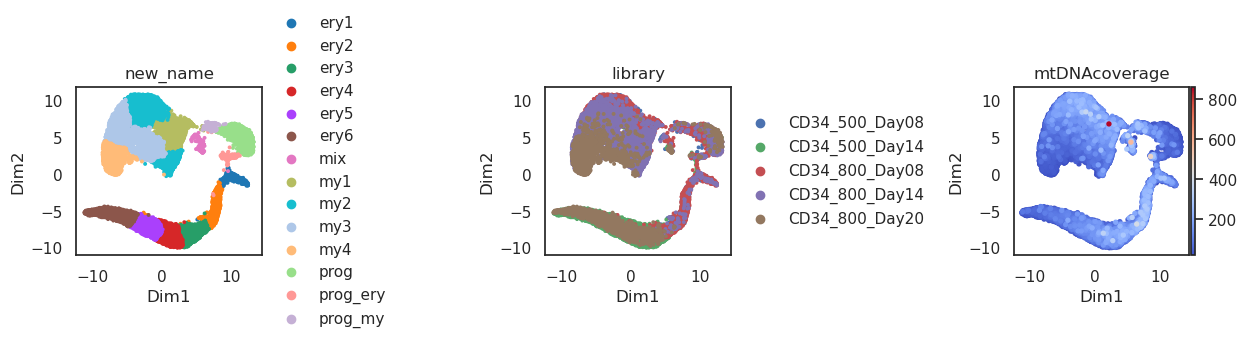

In [72]:
# sc.pl.scatter(mito_sce, x='X1', y='X2', color='new_name')
with plt.rc_context({'image.cmap': 'coolwarm', 'figure.figsize':[4,3]}):
    me.pl.scatter(adata, color=['new_name', 'library', 'mtDNAcoverage'])
plt.show()

### motif accessibility

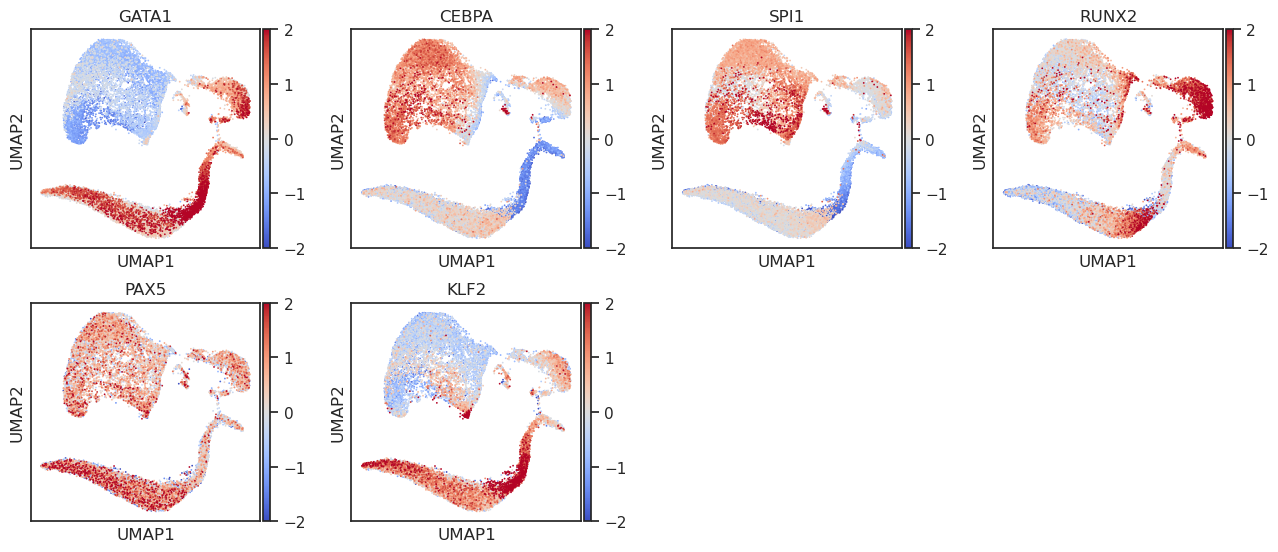

In [73]:
with plt.rc_context({'image.cmap': 'coolwarm', 'figure.figsize':[3,3]}):
    sc.pl.umap(adata, color=['GATA1', 'CEBPA', 'SPI1', 'RUNX2', 'PAX5', 'KLF2'], layer='z_norm', vmin=-2, vmax=2)


## MEGATRON identification of clones/colors

In [16]:
adata.obs['time'] = adata.obs['library'].apply(lambda x: int(x[-2:]))

In [17]:
adata.obs['time']

CD34_500_Day08-AAACGAAAGACAGCTG-1     8
CD34_500_Day08-AAACGAACATAGATAG-1     8
CD34_500_Day08-AAACGAAGTACGTAGG-1     8
CD34_500_Day08-AAACGAAGTTATGCAC-1     8
CD34_500_Day08-AAACTCGCAACTTGGT-1     8
                                     ..
CD34_800_Day20-TTTGTGTGTAAACGGC-1    20
CD34_800_Day20-TTTGTGTGTGCACATT-1    20
CD34_800_Day20-TTTGTGTGTTAAGTCC-1    20
CD34_800_Day20-TTTGTGTGTTTGACCA-1    20
CD34_800_Day20-TTTGTGTTCGTCTTAT-1    20
Name: time, Length: 18259, dtype: int64

# Clustering of clones by mtDNA mutations

In [18]:
%%time

me.tl.clone_distance(adata,
                     obsm='X_umap',
                     # anno_time='time',
                     anno_time=None,
                     method='geodesic',
                     n_jobs=8)

Finished: 0.26742138862609866 mins
CPU times: user 1min 26s, sys: 36.6 s, total: 2min 3s
Wall time: 16 s


In [19]:
me.tl.cluster_clones(adata,
                     n_clusters=3,
                     method='hierarchical')

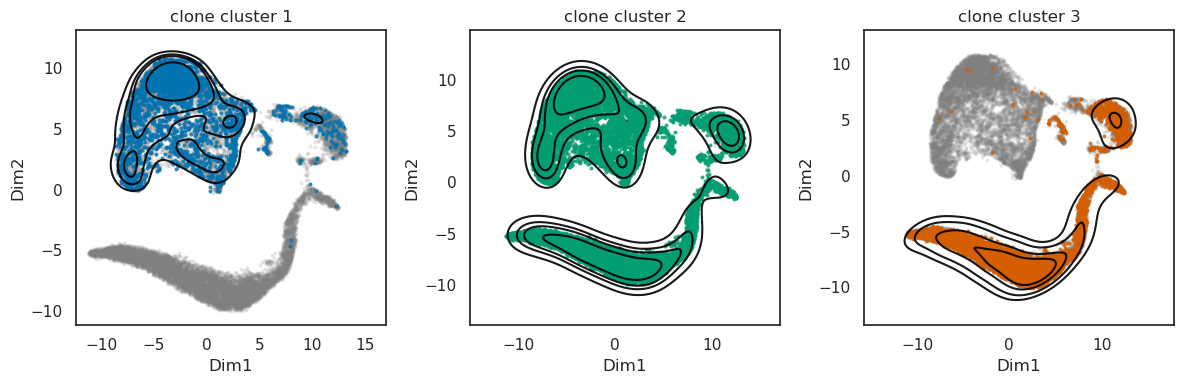

In [93]:
me.pl.clone_clusters(adata,
                    group='hierarchical',
                    obsm='X_umap',
                    show_contour=True, 
                    levels=5,
                    thresh=0.2)
plt.show()

# Cluster-based analysis of metaclones

In [286]:
%autoreload 2
me.tl.build_graph(adata, obsm='X_umap', k=3, n_clusters=50)

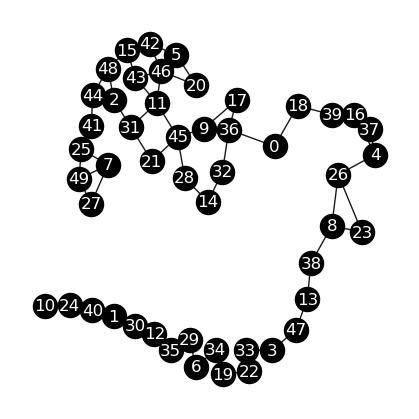

In [287]:
%autoreload 2
me.pl.cluster_graph(adata, node_color="black")
plt.show()

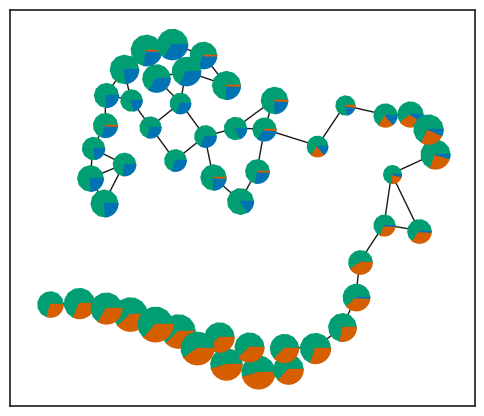

In [288]:
%autoreload 2

with plt.rc_context({'figure.figsize':[6,6]}):
    me.pl.cluster_pie_graph(adata)
    plt.gca().set_aspect("equal")
    plt.show()

In [295]:
import networkx as nx

In [296]:
progenitor_clusters = [46,27,14,25,66,65,3,41]
progenitor_clusters = [27,14,25,66,65,3]
progenitor_clusters = [39,16,37,4]


me.tl.calculate_pseudotime(adata, progenitor_clusters)
adata.uns['cluster_pseudotime']

,pseudotime
cluster,
39,0
16,0
37,0
4,0
18,1
26,1
0,2
8,2
23,2


In [316]:
arr = adata.obsm['X_clone'] @ pd.get_dummies(adata.uns['clone']['anno']['hierarchical']).values
clust_labels = adata.uns['clone']['anno']['hierarchical']
# adata.obsm['X_clone'].sum(axis=0)[:,(clust_labels=='3')]
max_clones = [(adata.obsm['X_clone'].sum(axis=0).A1 * (clust_labels==c)).argmax() for c in ['1','2','3']]
max_clones

[105, 0, 1]

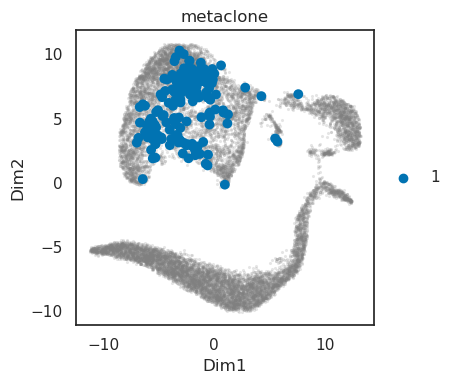

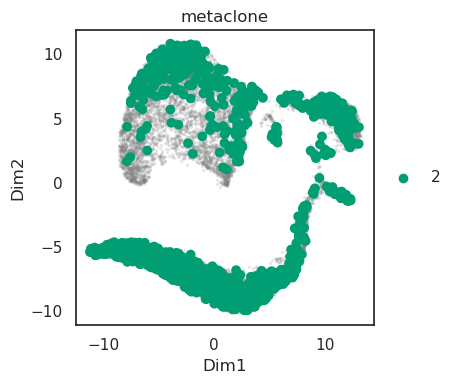

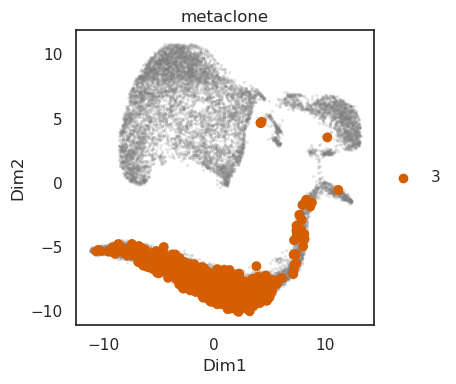

In [323]:
with plt.rc_context({'image.cmap': 'coolwarm',
                    'figure.figsize':[4.5,4]}):
    for i in range(3):
        me.pl.clones(adata, ids=adata.uns['clone']['anno'].index[max_clones[i]], obsm="X_umap", color=['metaclone'], )
        plt.show()

## graph-based pseudotime

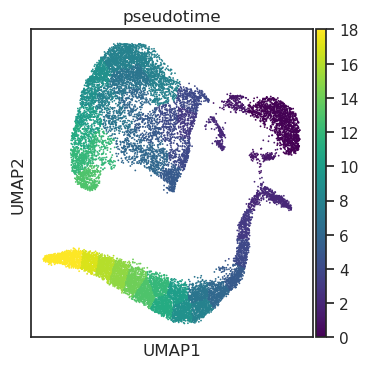

In [127]:
adata.obs['pseudotime']=adata.uns['cluster_pseudotime'].loc[adata.obs['cluster']].values
# adata.obs['pseudotime'] = (adata.obs['pseudotime']/adata.obs['pseudotime'].max()*n_pseudotime_bins).apply(np.ceil).astype(int)
sc.pl.umap(adata,color=['pseudotime'], cmap='viridis')

In [128]:
progenitor_cells = adata[adata.obs['cluster'].isin(progenitor_clusters)& adata.obs['library'].str.contains('Day08')]

# progenitor_cells = adata[adata.obs['cluster'].isin(progenitor_clusters) & adata.obs['metaclone'].isin(['1','3'])& adata.obs['library'].str.contains('Day08')]
progenitor_cells.obs

,sample,depth,FRIP,mtDNAcoverage,new_name,library,time,cluster,metaclone,pseudotime
CD34_500_Day08-AAACGAACATAGATAG-1,AAACGAACATAGATAG-1,33704.0,0.526466,55.30,prog,CD34_500_Day08,8,16,2,0
CD34_500_Day08-AAACGAAGTTATGCAC-1,AAACGAAGTTATGCAC-1,34093.0,0.545215,31.51,prog,CD34_500_Day08,8,37,3,0
CD34_500_Day08-AAACTCGCATGGATGG-1,AAACTCGCATGGATGG-1,47756.0,0.482829,102.19,prog,CD34_500_Day08,8,16,1,0
CD34_500_Day08-AAACTGCAGTCTCGAT-1,AAACTGCAGTCTCGAT-1,35822.0,0.620596,37.83,prog,CD34_500_Day08,8,37,2,0
CD34_500_Day08-AAAGATGCATCGACCG-1,AAAGATGCATCGACCG-1,27962.0,0.611866,35.24,prog,CD34_500_Day08,8,4,2,0
...,...,...,...,...,...,...,...,...,...,...
CD34_800_Day08-TTTGTGTCAATGTAAG-1,TTTGTGTCAATGTAAG-1,17905.0,0.558838,28.06,prog,CD34_800_Day08,8,16,2,0
CD34_800_Day08-TTTGTGTCACACACCG-1,TTTGTGTCACACACCG-1,38074.0,0.468351,67.52,prog,CD34_800_Day08,8,39,2,0
CD34_800_Day08-TTTGTGTGTACTTCGA-1,TTTGTGTGTACTTCGA-1,31420.0,0.521260,45.21,prog,CD34_800_Day08,8,39,2,0
CD34_800_Day08-TTTGTGTTCCAAGTCA-1,TTTGTGTTCCAAGTCA-1,33036.0,0.627316,33.03,prog,CD34_800_Day08,8,16,3,0


In [129]:

progenitor_clusters = [27,14,25,66,65,3]


In [130]:
progenitor_cells

View of AnnData object with n_obs × n_vars = 1055 × 870
    obs: 'sample', 'depth', 'FRIP', 'mtDNAcoverage', 'new_name', 'library', 'time', 'cluster', 'metaclone', 'pseudotime'
    var: 'fractionMatches', 'fractionBackgroundOverlap'
    uns: 'X_name', 'clone', 'color', 'cluster_pos', 'cluster_pdist', 'cluster_edgelist', 'cluster_pseudotime'
    obsm: 'X_umap', 'X_clone'
    layers: 'z', 'z_norm'

# Differential testing

In [132]:
# ??me.tl.differential_test_vars

In [193]:
%autoreload 2
import warnings

group1 = ['1']
group2 = ['3']
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    me.tl.differential_test_vars(progenitor_cells, group1, group2, test="lmm", batch='library')

me.tl.differential_test_vars(progenitor_cells, group1, group2, test="t-test")
me.tl.differential_test_vars(progenitor_cells, group1, group2, test="wilcoxon")


In [194]:
progenitor_cells.uns['lmm_MEGATRON']

,coef,p_value,gene,p_value_corr
732,-3.913773e-03,0.000516,RUNX1,0.144479
733,-6.314020e-03,0.000902,ENSG00000250096,0.144479
731,-6.314020e-03,0.000902,RUNX2,0.144479
800,-6.573756e-03,0.001103,CBFB,0.144479
450,-1.008051e-02,0.003510,HOXA7,0.144479
...,...,...,...,...
576,6.263051e-06,0.998355,AC2261502,0.999833
472,-3.121215e-06,0.998787,HNF1A,0.999833
811,-1.508841e-06,0.999133,BPTF,0.999833
418,1.436125e-06,0.999701,EVX1,0.999833


In [195]:
progenitor_cells.uns['wilcoxon_MEGATRON']

,coef,p_value,gene,p_value_corr
154,0.034524,0.000516,CEBPA,0.205807
55,0.010241,0.000679,TCF12,0.205807
121,0.034757,0.000840,ATF4,0.205807
132,0.036309,0.000946,NFIL3,0.205807
111,0.035177,0.001878,HLF,0.211152
...,...,...,...,...
420,0.002389,0.991768,MEOX2,0.996349
509,0.006323,0.994512,ZHX1,0.996804
411,0.000323,0.994512,DLX5,0.996804
692,0.001300,0.997256,NR2C2,0.997256


In [196]:
progenitor_cells.uns['t-test_MEGATRON']

,coef,p_value,gene,p_value_corr
154,0.034524,0.000134,CEBPA,0.053811
132,0.036309,0.000180,NFIL3,0.053811
121,0.034757,0.000186,ATF4,0.053811
139,0.034114,0.000788,CEBPB,0.129375
109,0.043837,0.000877,DBP,0.129375
...,...,...,...,...
96,0.000061,0.991161,TCF4,0.995334
705,0.000060,0.991902,TP53,0.995334
664,-0.000034,0.993953,NR2E1,0.996243
654,-0.000027,0.996104,NR1H4,0.997251


In [203]:
test_type='t-test_MEGATRON'
alpha = 0.1
test_df = progenitor_cells.uns[test_type].assign(
    significant=lambda x: x['p_value_corr']<alpha
)
signif_results = test_df.query('significant').sort_values('p_value')
signif_results

,coef,p_value,gene,p_value_corr,significant
154,0.034524,0.000134,CEBPA,0.053811,True
132,0.036309,0.000180,NFIL3,0.053811,True
121,0.034757,0.000186,ATF4,0.053811,True


In [206]:
signif_genes = signif_results['gene']

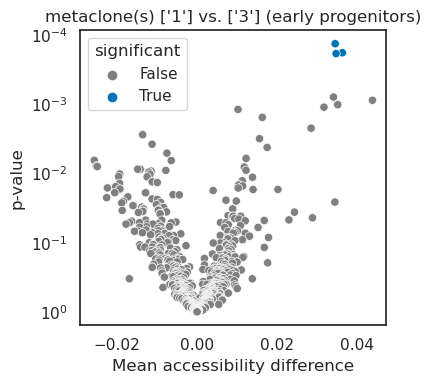

In [326]:
with plt.rc_context({'figure.figsize': [4,4]}):
    sns.scatterplot(x='coef',y='p_value',hue='significant', data=test_df,
                    palette=["grey",clone_pal[0]])
    for i, gene in enumerate(signif_genes):
        row=test_df.query(f'gene=="{gene}"')
        # plt.text(row['coef'],row['p_value'], s=gene, size=8)
        plt.ylabel('p-value')
        plt.xlabel('Mean accessibility difference')
        plt.title(f'metaclone(s) {group1} vs. {group2} (early progenitors)')
        # break
        # plt.text(row['coef']+i*0.005-i**2*0.004,row['p_value'], s=gene)
    plt.tight_layout()
    plt.yscale('log')
    plt.gca().invert_yaxis()
    plt.show()

In [208]:
adata.obs['library']

CD34_500_Day08-AAACGAAAGACAGCTG-1    CD34_500_Day08
CD34_500_Day08-AAACGAACATAGATAG-1    CD34_500_Day08
CD34_500_Day08-AAACGAAGTACGTAGG-1    CD34_500_Day08
CD34_500_Day08-AAACGAAGTTATGCAC-1    CD34_500_Day08
CD34_500_Day08-AAACTCGCAACTTGGT-1    CD34_500_Day08
                                          ...      
CD34_800_Day20-TTTGTGTGTAAACGGC-1    CD34_800_Day20
CD34_800_Day20-TTTGTGTGTGCACATT-1    CD34_800_Day20
CD34_800_Day20-TTTGTGTGTTAAGTCC-1    CD34_800_Day20
CD34_800_Day20-TTTGTGTGTTTGACCA-1    CD34_800_Day20
CD34_800_Day20-TTTGTGTTCGTCTTAT-1    CD34_800_Day20
Name: library, Length: 18259, dtype: category
Categories (5, object): ['CD34_500_Day08', 'CD34_500_Day14', 'CD34_800_Day08', 'CD34_800_Day14', 'CD34_800_Day20']

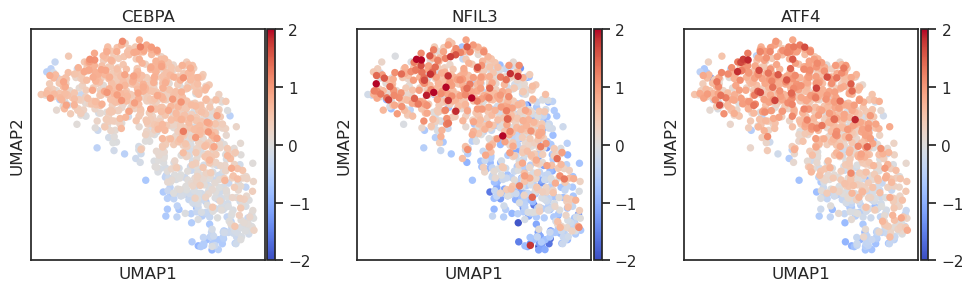

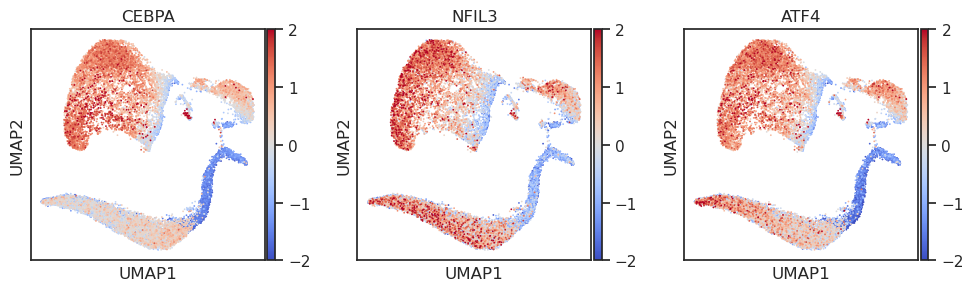

In [209]:
with plt.rc_context({'image.cmap': 'coolwarm',
                    'figure.figsize':[3,3]}):
    # me.pl.scatter(progenitor_cells, color=signif_genes)
    sc.pl.umap(progenitor_cells, color=list(signif_genes), layer="z_norm", vmin=-2, vmax=2)
    sc.pl.umap(adata, color=list(signif_genes), layer="z_norm", vmin=-2, vmax=2)

    # me.pl.scatter(progenitor_cells[progenitor_cells.obs['metaclone']=='1'], color=['CEBPB','NFIL3','GATA1'])
    # me.pl.scatter(progenitor_cells[progenitor_cells.obs['metaclone']=='3'], color=['CEBPB','NFIL3','GATA1'])


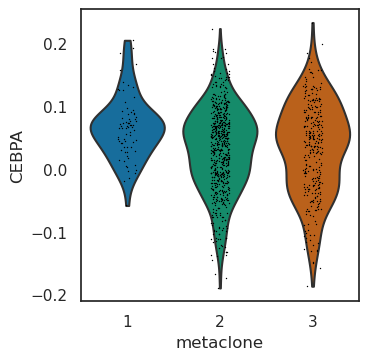

In [210]:
sc.pl.violin(progenitor_cells, ['CEBPA'], groupby="metaclone", palette=sns.color_palette())
# plt.title("Accessibility (early progenitors)")

/tmp/ipykernel_3474/3936873587.py:15: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.lineplot(x=plot_adata.obs['pseudotime'],y=gene_value, hue=plot_adata.obs['metaclone'], palette=sns.color_palette()[0::2])


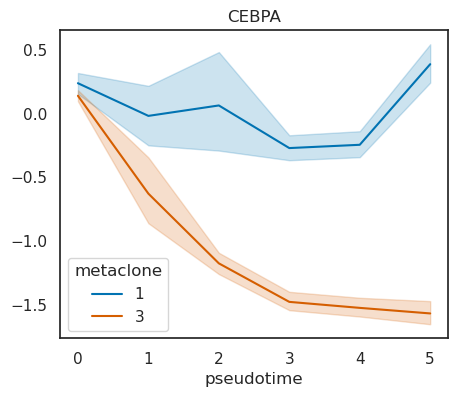

In [217]:
# sc.pl.scatter(adata,x='pseudotime',y='CEBPA', color="metaclone", layers='z_norm')
# for m in ['1','2','3']:
gene = 'CEBPA'
max_pseudotime=5
plot_adata = adata[(adata.obs['pseudotime']<=max_pseudotime) & (adata.obs['metaclone'].isin(group1+group2))]
gene_value = plot_adata[:,gene].layers['z_norm'].copy().squeeze()
# gene_value = plot_adata[:,gene].X.copy().squeeze()


# print(plot_values.)
with plt.rc_context({'figure.figsize':[5,4]}):
    plt.title(gene)
    # sns.violinplot(x=plot_adata.obs['pseudotime'],y=gene_value, hue=plot_adata.obs['metaclone'])
    # sns.stripplot(x=plot_adata.obs['pseudotime'],y=gene_value, hue=plot_adata.obs['metaclone'], alpha=0.8, size=2)
    sns.lineplot(x=plot_adata.obs['pseudotime'],y=gene_value, hue=plot_adata.obs['metaclone'], palette=sns.color_palette()[0::2])
    plt.show()
    